# Spatial Data

In [1]:
!pip -q install scanpy squidpy anndata leidenalg louvain igraph scikit-learn scipy tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 70.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 86.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 94.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 115.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.3/183.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 17.3 MB/s eta 0:00:0

In [2]:
!pip -q install scikit-misc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 15.0 MB/s eta 0:00:00


In [3]:
import os, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import scipy.sparse as sp

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

warnings.filterwarnings("ignore")
sc.settings.verbosity = 2

SEED = 0
np.random.seed(SEED)

/usr/lib/python3.12/importlib/__init__.py:90: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)


# Figshare public API

In [4]:
# ============================================================
# [Cell 2] Choose a public Visium dataset (10x via squidpy.datasets.visium)
# ============================================================
# Good options (all supported by squidpy.datasets.visium):
# - "V1_Breast_Cancer_Block_A_Section_1" (classic demo)  [default]
# - "V1_Adult_Mouse_Brain"
# - "V1_Human_Heart"
# - "V1_Human_Lymph_Node"
# - "V1_Human_Brain_Section_1"
#
# Docs list the allowed sample_id values.  :contentReference[oaicite:3]{index=3}

OUT_ROOT = Path("/content/visium_benchmark")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

SAMPLE_ID = "V1_Breast_Cancer_Block_A_Section_2"
DATA_DIR = OUT_ROOT / "10x_visium_download"
DATA_DIR.mkdir(parents=True, exist_ok=True)

obj = sq.datasets.visium(SAMPLE_ID, include_hires_tiff=False, base_dir=str(DATA_DIR))

# Depending on squidpy version, obj may be AnnData OR a path
if isinstance(obj, sc.AnnData):
    adata = obj
else:
    adata = sq.read.visium(obj, counts_file="filtered_feature_bc_matrix.h5", load_images=True)

adata.var_names_make_unique()
print("Loaded adata:", adata)
print("spatial in obsm?", "spatial" in adata.obsm)

SHA256 hash of downloaded file: 15fcf837478bcba847b50e393b016f95f02067ea930e81f96b103f2a14bf6db0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: e325b4e53f0036a71904cea6b7cd65945f10c25cf2ef8e2f681de9ac1ff7766c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


reading /content/visium_benchmark/10x_visium_download/V1_Breast_Cancer_Block_A_Section_2/filtered_feature_bc_matrix.h5
 (0:00:02)
Loaded adata: AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
spatial in obsm? True


# PCA

In [5]:
# ============================================================
# [Cell 3] Preprocess (standard ST pipeline)
# ============================================================
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.filter_cells(adata, min_counts=1)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="seurat")
adata = adata[:, adata.var["highly_variable"]].copy()

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=50, svd_solver="arpack")

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)

# spatial neighbors (Squidpy version-safe)
if "spatial" not in adata.obsm:
    raise ValueError("No adata.obsm['spatial'] found.")

if {"array_row", "array_col"}.issubset(set(adata.obs.columns)):
    sq.gr.spatial_neighbors(adata, coord_type="grid")
else:
    sq.gr.spatial_neighbors(adata, coord_type="generic")

print("Done preprocessing. obsp keys:", list(adata.obsp.keys()))

filtered out 11529 genes that are detected in less than 1 counts
normalizing counts per cell
    finished (0:00:07)
extracting highly variable genes
    finished (0:00:02)
computing PCA
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:29)
computing UMAP
    finished (0:00:07)
Creating graph using `grid` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Done preprocessing. obsp keys: ['distances', 'connectivities', 'spatial_connectivities', 'spatial_distances']


## Cluster Methods

In [6]:
# ============================================================
# One-shot clustering cell (defines funcs + runs) — Colab-safe
# ============================================================
import time
import numpy as np
import scipy.sparse as sp
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# assumes SEED and adata already exist from earlier cells
# If SEED not defined, set it:
try:
    SEED
except NameError:
    SEED = 0

def _t(msg):
    print(f"\n[{time.strftime('%H:%M:%S')}] {msg}", flush=True)

def run_expr_graph_clusterings(adata, resolution=1.0):
    _t("Running Leiden (expression kNN graph)...")
    t0 = time.time()
    sc.tl.leiden(adata, resolution=resolution, key_added=f"leiden_expr_r{resolution}")
    _t(f"Leiden done in {time.time()-t0:.1f}s")

    _t("Skipping Louvain (optional; can hang on Colab).")

def run_expr_embedding_clusterings(adata, k=7):
    _t("Running KMeans/GMM on PCA embedding...")
    t0 = time.time()
    X = adata.obsm["X_pca"]
    adata.obs["expr_kmeans"] = KMeans(n_clusters=k, random_state=SEED, n_init=10).fit_predict(X).astype(str)
    adata.obs["expr_gmm"] = GaussianMixture(n_components=k, random_state=SEED).fit_predict(X).astype(str)
    _t(f"KMeans+GMM done in {time.time()-t0:.1f}s")

def run_combined_graph_leiden(adata, w_expr=1.0, w_spatial=3.0, resolution=1.0, key_added=None):
    if key_added is None:
        key_added = f"leiden_comb_wE{w_expr}_wS{w_spatial}_r{resolution}"
    _t(f"Running Leiden on combined graph (w_expr={w_expr}, w_spatial={w_spatial})...")
    t0 = time.time()
    C_expr = adata.obsp["connectivities"]
    C_sp   = adata.obsp["spatial_connectivities"]
    C = w_expr * C_expr + w_spatial * C_sp
    sc.tl.leiden(adata, adjacency=C, resolution=resolution, key_added=key_added)
    _t(f"Combined-graph Leiden done in {time.time()-t0:.1f}s")

def spatial_smoothing_X(X, A, alpha=0.6):
    A = A.tocsr()
    deg = np.asarray(A.sum(axis=1)).ravel()
    deg[deg == 0] = 1.0
    Dinv = sp.diags(1.0 / deg)
    Anorm = Dinv @ A
    return alpha * X + (1 - alpha) * (Anorm @ X)

def run_spatial_smooth_leiden(adata, alpha=0.6, resolution=1.0, key_added=None):
    if key_added is None:
        key_added = f"leiden_smooth_a{alpha}_r{resolution}"

    _t(f"Running spatial smoothing + Leiden (alpha={alpha})...")
    t0 = time.time()

    X_backup = adata.X
    X_pca_backup = adata.obsm.get("X_pca", None)
    try:
        adata.X = spatial_smoothing_X(adata.X, adata.obsp["spatial_connectivities"], alpha=alpha)

        # lighter settings for speed
        sc.pp.scale(adata, max_value=10)
        sc.tl.pca(adata, n_comps=30, svd_solver="arpack")
        sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

        sc.tl.leiden(adata, resolution=resolution, key_added=key_added)
        _t(f"Spatial-smooth Leiden done in {time.time()-t0:.1f}s")
    finally:
        adata.X = X_backup
        if X_pca_backup is not None:
            adata.obsm["X_pca"] = X_pca_backup

# -------------------------
# RUN
# -------------------------
K = 7

_t("Starting clustering pipeline...")
_t(f"Cells/spots: {adata.n_obs}, genes: {adata.n_vars}")
_t(f"Has connectivities: {'connectivities' in adata.obsp}")
_t(f"Has spatial_connectivities: {'spatial_connectivities' in adata.obsp}")

run_expr_embedding_clusterings(adata, k=K)
run_expr_graph_clusterings(adata, resolution=1.0)
run_combined_graph_leiden(adata, w_expr=1.0, w_spatial=3.0, resolution=1.0)
run_spatial_smooth_leiden(adata, alpha=0.6, resolution=1.0)

cluster_cols = [c for c in adata.obs.columns if ("leiden" in c) or c.startswith("expr_")]
_t(f"Cluster outputs created: {cluster_cols}")
print(cluster_cols)


[18:49:54] Starting clustering pipeline...

[18:49:54] Cells/spots: 3987, genes: 3000

[18:49:54] Has connectivities: True

[18:49:54] Has spatial_connectivities: True

[18:49:54] Running KMeans/GMM on PCA embedding...

[18:49:56] KMeans+GMM done in 2.0s

[18:49:56] Running Leiden (expression kNN graph)...
running Leiden clustering
    finished (0:00:01)

[18:49:58] Leiden done in 1.5s

[18:49:58] Skipping Louvain (optional; can hang on Colab).

[18:49:58] Running Leiden on combined graph (w_expr=1.0, w_spatial=3.0)...
running Leiden clustering
    finished (0:00:03)

[18:50:01] Combined-graph Leiden done in 3.4s

[18:50:01] Running spatial smoothing + Leiden (alpha=0.6)...
computing PCA
    with n_comps=30
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00)
running Leiden clustering
    finished (0:00:01)

[18:50:06] Spatial-smooth Leiden done in 4.7s

[18:50:06] Cluster outputs created: ['expr_kmeans', 'expr_gmm', 'leiden_expr_r1.0', '

In [7]:
# # ============================================================
# # [Cell 5] Internal metrics + spatial coherence score
# # ============================================================
# from sklearn.metrics import pairwise_distances

# def spatial_edge_agreement(adata, labels: pd.Series) -> float:
#     A = adata.obsp["spatial_connectivities"].tocsr()
#     rows, cols = A.nonzero()
#     if len(rows) == 0:
#         return np.nan
#     lab = labels.astype(str).to_numpy()
#     return float(np.mean(lab[rows] == lab[cols]))

# def score_one(adata, pred_col):
#     pred = adata.obs[pred_col].astype(str)
#     X = adata.obsm["X_pca"]
#     out = {
#         "method": pred_col,
#         "n_clusters": int(pred.nunique()),
#         "silhouette": np.nan,
#         "calinski_harabasz": np.nan,
#         "davies_bouldin": np.nan,
#         "spatial_edge_agreement": spatial_edge_agreement(adata, pred),
#     }
#     if pred.nunique() >= 2 and X.shape[0] > pred.nunique():
#         try: out["silhouette"] = float(silhouette_score(X, pred))
#         except: pass
#         try: out["calinski_harabasz"] = float(calinski_harabasz_score(X, pred))
#         except: pass
#         try: out["davies_bouldin"] = float(davies_bouldin_score(X, pred))
#         except: pass
#     return out

# results = pd.DataFrame([score_one(adata, c) for c in cluster_cols]).sort_values(
#     by=["spatial_edge_agreement", "silhouette"],
#     ascending=False
# )

# out_csv = OUT_ROOT / f"{SAMPLE_ID}_metrics.csv"
# results.to_csv(out_csv, index=False)
# print("Saved:", out_csv)
# results

In [8]:
# # ============================================================
# # [Cell 6] Plots (spatial + UMAP)
# # ============================================================
# top_methods = results["method"].head(6).tolist()
# print("Top methods:", top_methods)

# sc.pl.spatial(adata, color=top_methods, spot_size=1.3, ncols=3)
# sc.pl.umap(adata, color=top_methods, ncols=3)

# ST-specific clustering methods

In [9]:
!curl -LsSf https://astral.sh/uv/install.sh | sh

downloading uv 0.9.24 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


In [10]:
# import os
# os.environ["PATH"] = os.path.expanduser("~/.local/bin") + ":" + os.environ["PATH"]
# !uv --version

In [11]:
#!uv pip install --system -U pip setuptools wheel
!uv pip install --system scanpy squidpy scikit-learn scipy scikit-misc igraph leidenalg louvain

Using Python 3.12.12 environment at: /usr
Audited 8 packages in 133ms


In [12]:
# Replace <WHEEL_INDEX_URL> with the printed whl URL
#!uv pip install --system pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv -f <WHEEL_INDEX_URL>
!uv pip install --system torch-geometric
!uv pip install --system GraphST SpaGCN

Using Python 3.12.12 environment at: /usr
Resolved 23 packages in 231ms
Prepared 1 package in 89ms
Installed 1 package in 12ms
 + torch-geometric==2.7.0
Using Python 3.12.12 environment at: /usr
Resolved 75 packages in 1.12s
Prepared 3 packages in 10ms
Installed 3 packages in 1ms
 + graphst==1.1.1
 + python-igraph==1.0.0
 + spagcn==1.2.7


In [13]:
!uv pip install --system SpaGCN GraphST

Using Python 3.12.12 environment at: /usr
Audited 2 packages in 95ms


In [14]:
!uv pip install POT

Using Python 3.12.12 environment at: /usr
Resolved 3 packages in 30ms
Prepared 1 package in 33ms
Installed 1 package in 2ms
 + pot==0.9.6.post1


In [15]:
# import torch, re
# print("torch:", torch.__version__)
# print("cuda :", torch.version.cuda, "available:", torch.cuda.is_available())

# torch_ver = torch.__version__.split("+")[0]
# if torch.cuda.is_available() and torch.version.cuda:
#     cuda_tag = "cu" + re.sub(r"\D", "", torch.version.cuda)   # e.g., "12.1" -> "cu121"
# else:
#     cuda_tag = "cpu"

# whl = f"https://data.pyg.org/whl/torch-{torch_ver}+{cuda_tag}.html"
# print("PyG wheel index:", whl)

In [16]:
!pip -q install POT GraphST

In [17]:
import numpy as np, scanpy as sc, squidpy as sq
import ot
import GraphST
import SpaGCN
print("numpy:", np.__version__)
print("scanpy:", sc.__version__)
print("squidpy:", sq.__version__)
print("ot (POT):", ot.__version__)
print("GraphST imported ✅")
print("SpaGCN imported ✅")

numpy: 2.0.2
scanpy: 1.11.5
squidpy: 1.7.0
ot (POT): 0.9.6.post1
GraphST imported ✅
SpaGCN imported ✅


In [18]:
!pip show GraphST

Name: GraphST
Version: 1.1.1
Summary: Spatially informed clustering, integration, and deconvolution of spatial transcriptomics with GraphST
Home-page: https://github.com/JinmiaoChenLab/GraphST
Author: Yahui Long
Author-email: longyh@immunol.a-star.edu.sg
License: MIT
Location: /usr/local/lib/python3.12/dist-packages
Requires: requests
Required-by: 


# GraphST

In [19]:
import scanpy as sc
import numpy as np
from GraphST import GraphST

SEED = 0
np.random.seed(SEED)

K = 7  # choose your target clusters

# Train
model = GraphST.GraphST(adata, device="cuda")  # force CPU for stability
adata_g = model.train()

# Find the embedding key GraphST produced
rep_candidates = ["GraphST", "X_graphst", "X_emb", "emb", "X_embedding"]
use_rep = next((r for r in rep_candidates if r in adata_g.obsm), None)
print("GraphST embedding rep:", use_rep)

if use_rep is None:
    # fallback
    use_rep = "X_pca"
    print("No GraphST embedding found; fallback to X_pca")

# Cluster on embedding with Leiden
sc.pp.neighbors(adata_g, use_rep=use_rep, n_neighbors=15)
sc.tl.leiden(adata_g, resolution=1.0, key_added="GraphST_raw")

# Copy labels back
adata.obs["GraphST"] = adata_g.obs["GraphST_raw"].reindex(adata.obs_names).astype(str).values
print("✅ GraphST clusters:", adata.obs["GraphST"].nunique())

Begin to train ST data...


100%|██████████| 600/600 [00:38<00:00, 15.61it/s]


Optimization finished for ST data!
GraphST embedding rep: emb
computing neighbors
    finished (0:00:03)
running Leiden clustering
    finished (0:00:01)
✅ GraphST clusters: 14


# Evaluation

In [20]:
# ============================================================
# [Cell 5] Evaluation: internal metrics + spatial coherence + composite score + save
# ============================================================
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# --- checks
assert "X_pca" in adata.obsm, "Missing adata.obsm['X_pca'] (run PCA first)"
assert "spatial_connectivities" in adata.obsp, "Missing adata.obsp['spatial_connectivities'] (run sq.gr.spatial_neighbors)"

# --- collect clustering columns (robust + force GraphST)
cluster_cols = []

# baselines
cluster_cols += [c for c in adata.obs.columns if c.startswith("expr_")]
cluster_cols += [c for c in adata.obs.columns if ("leiden" in c.lower()) or ("louvain" in c.lower())]

# ST methods (force include if present)
preferred = ["GraphST", "SpaGCN", "STAGATE", "SpaceFlow", "BANKSY"]
for c in preferred:
    if c in adata.obs.columns:
        cluster_cols.append(c)

# if GraphST isn't found, show similar names (helps debugging)
if "GraphST" not in adata.obs.columns:
    print("⚠️ GraphST column not found. Similar columns:",
          [c for c in adata.obs.columns if "graph" in c.lower()])

# de-duplicate keep order
seen = set()
cluster_cols = [c for c in cluster_cols if not (c in seen or seen.add(c))]

print("Evaluating methods:", cluster_cols)


# --- helper: spatial edge agreement (neighbors share same label)
def spatial_edge_agreement(adata, labels: pd.Series) -> float:
    A = adata.obsp["spatial_connectivities"].tocsr()
    rows, cols = A.nonzero()
    if len(rows) == 0:
        return np.nan
    lab = labels.astype(str).to_numpy()
    return float(np.mean(lab[rows] == lab[cols]))

# --- helper: internal metrics on X_pca (consistent across methods)
def internal_metrics(adata, labels: pd.Series):
    labels = labels.astype(str)
    X = adata.obsm["X_pca"]
    out = {"silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan}
    k = labels.nunique()

    if k >= 2 and X.shape[0] > k:
        try: out["silhouette"] = float(silhouette_score(X, labels))
        except: pass
        try: out["calinski_harabasz"] = float(calinski_harabasz_score(X, labels))
        except: pass
        try: out["davies_bouldin"] = float(davies_bouldin_score(X, labels))
        except: pass

    return out

# --- compute table
rows = []
for m in cluster_cols:
    lab = adata.obs[m]
    r = {"method": m, "n_clusters": int(lab.nunique())}
    r.update(internal_metrics(adata, lab))
    r["spatial_edge_agreement"] = spatial_edge_agreement(adata, lab)
    rows.append(r)

results = pd.DataFrame(rows)

# --- optional composite score (higher better overall)
def zscore(s):
    s = s.astype(float)
    if np.all(np.isnan(s)):
        return s
    mu = np.nanmean(s); sd = np.nanstd(s)
    if sd == 0 or np.isnan(sd):
        return s * 0
    return (s - mu) / sd

results["z_spatial"] = zscore(results["spatial_edge_agreement"])
results["z_sil"]     = zscore(results["silhouette"])
results["z_ch"]      = zscore(results["calinski_harabasz"])
results["z_db"]      = -zscore(results["davies_bouldin"])  # lower DB is better → negate

results["score"] = results[["z_spatial","z_sil","z_ch","z_db"]].mean(axis=1, skipna=True)

# --- sort (composite first, then spatial, then silhouette)
results = results.sort_values(by=["score","spatial_edge_agreement","silhouette"], ascending=False).reset_index(drop=True)

# --- save (prefer your OUT_ROOT/SAMPLE_ID convention if available)
try:
    out_csv = OUT_ROOT / f"{SAMPLE_ID}_metrics.csv"
except Exception:
    out_csv = "st_clustering_evaluation.csv"

results.to_csv(out_csv, index=False)
print("Saved:", out_csv)

results

Evaluating methods: ['expr_kmeans', 'expr_gmm', 'leiden_expr_r1.0', 'leiden_comb_wE1.0_wS3.0_r1.0', 'leiden_smooth_a0.6_r1.0', 'GraphST']
Saved: /content/visium_benchmark/V1_Breast_Cancer_Block_A_Section_2_metrics.csv


,method,n_clusters,silhouette,calinski_harabasz,davies_bouldin,spatial_edge_agreement,z_spatial,z_sil,z_ch,z_db,score
0,expr_kmeans,7,0.118601,350.056244,2.229111,0.724307,-0.728805,1.709340,1.789033,1.392021,1.040397
1,GraphST,14,0.069821,160.416672,2.661425,0.844379,0.640157,-0.073618,-0.379911,0.479651,0.166570
2,leiden_expr_r1.0,18,0.069197,157.945801,2.480477,0.716302,-0.820069,-0.096434,-0.408171,0.861528,-0.115786
3,leiden_comb_wE1.0_wS3.0_r1.0,14,0.057845,122.280754,3.430715,0.940179,1.732383,-0.511346,-0.816078,-1.143883,-0.184731
4,expr_gmm,7,0.086944,268.622162,3.506513,0.688673,-1.135077,0.552245,0.857656,-1.303849,-0.257257
5,leiden_smooth_a0.6_r1.0,27,0.028603,102.481216,3.023966,0.815545,0.311410,-1.580186,-1.042529,-0.285468,-0.649193


## Cluster PLot

In [21]:
top_methods = ["GraphST"] + [m for m in results["method"].head(6).tolist() if m != "GraphST"]
top_methods = top_methods[:6]

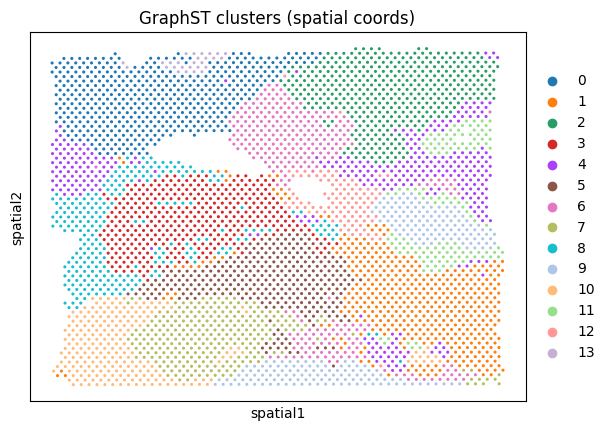

In [22]:
import scanpy as sc

# GraphST spatial domains
sc.pl.embedding(
    adata,
    basis="spatial",
    color="GraphST",
    s=20,
    title="GraphST clusters (spatial coords)"
)

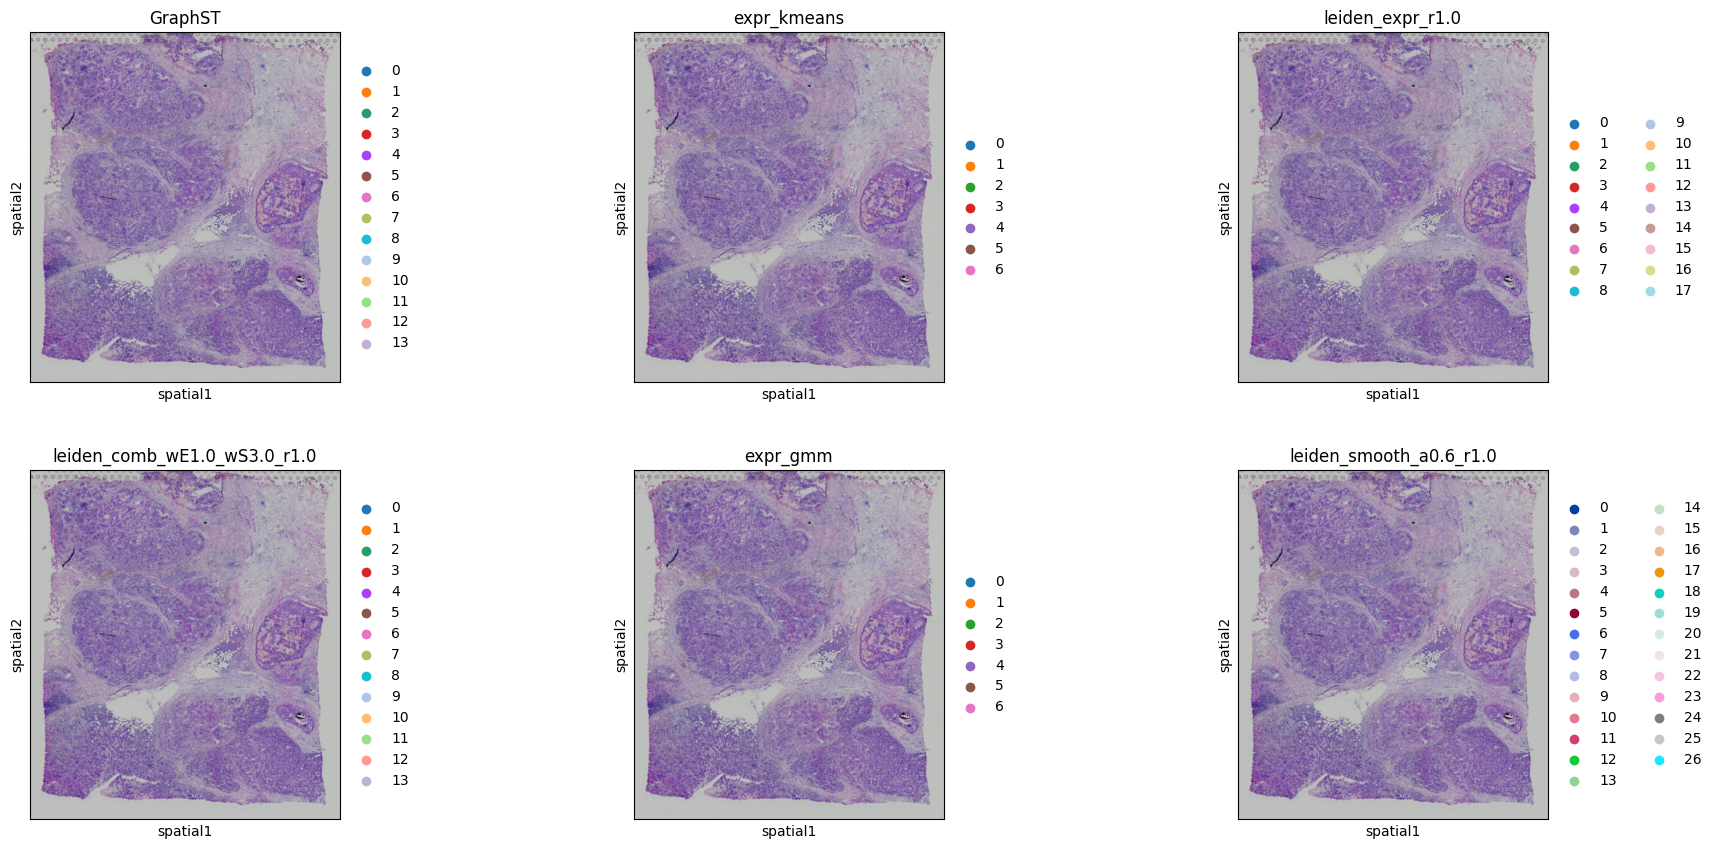

In [23]:
sc.pl.spatial(adata, color=top_methods, spot_size=1.3, ncols=3)

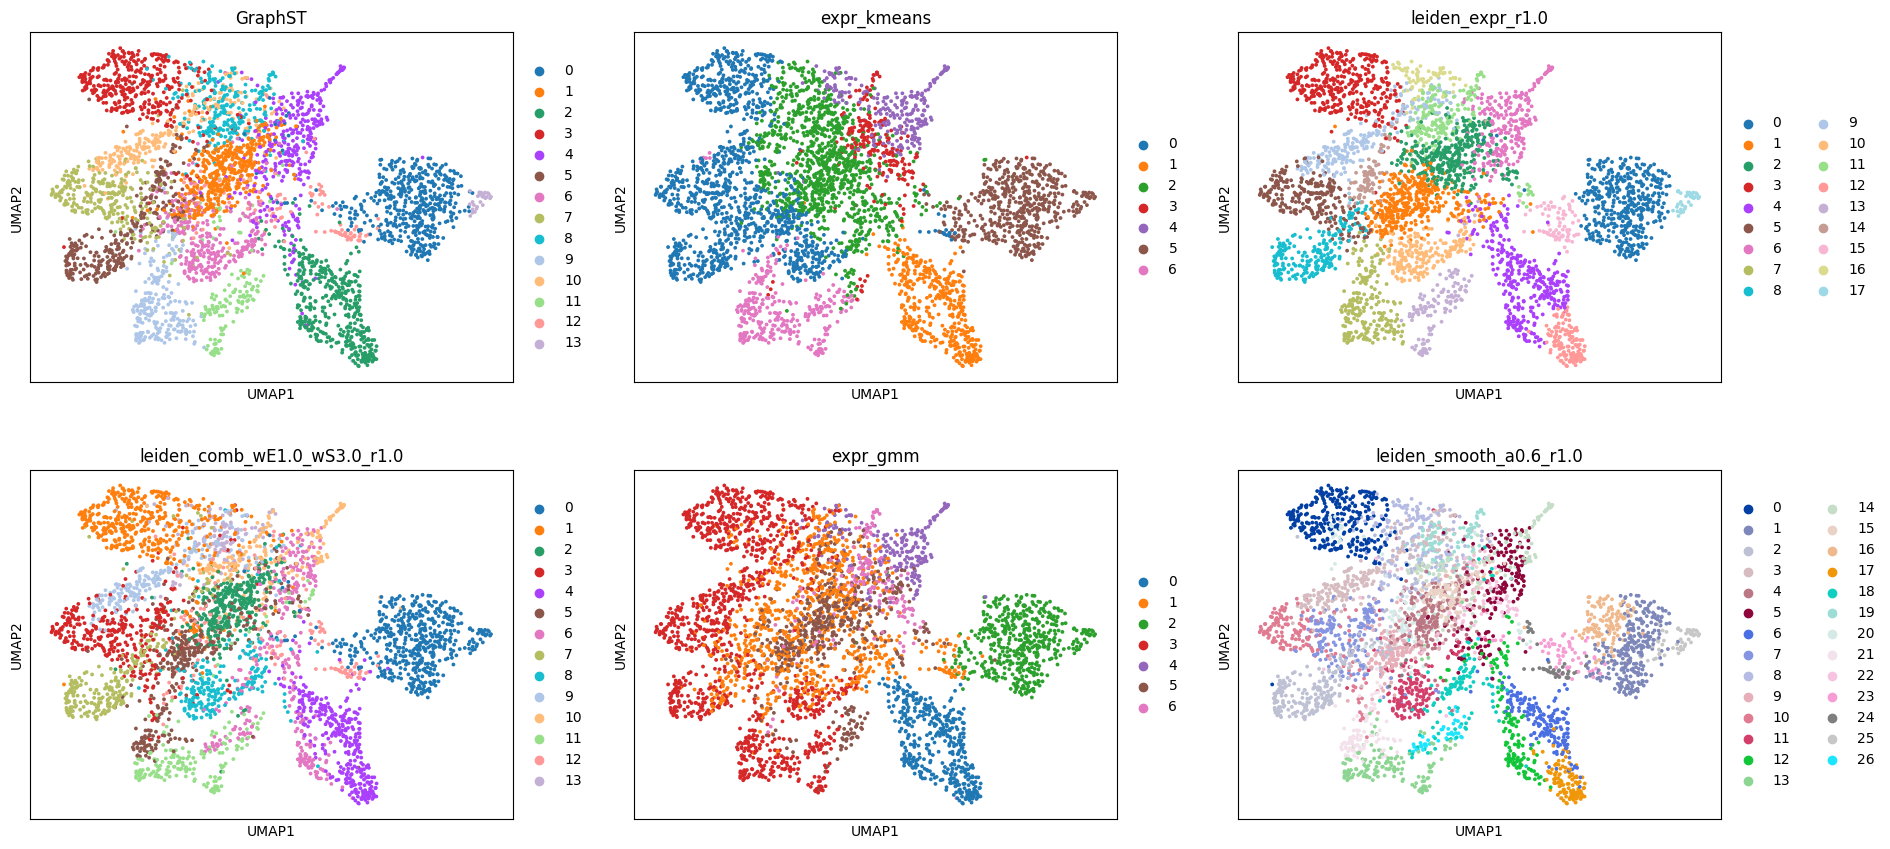

In [24]:
sc.pl.umap(adata, color=top_methods, ncols=3)